In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import re
import copy
import json

import datetime as dt
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm

# Calculated Lambda

In [3]:
viscat_rename=list(pd.read_csv('viscat_rename.csv')['0'])

In [4]:
cal_lam=pd.read_csv('lam_exp1_g1.csv')

for i in range(len(viscat_rename)):
    cal_lam=cal_lam.rename(index={i: viscat_rename[i]})
cal_lam

,lam_pd,lam_nonpd
HEMATOCRIT,2.917939,3.917939
HEMOGLOBIN,2.917939,3.917939
WHITE_BLOOD_CELL,2.913844,3.913844
MEAN_CELL_VOLUME,2.913844,3.913844
RED_CELL_DIAMETER_WIDTH,2.916615,3.916615
RED_BLOOD_CELL,2.913844,3.913844
MEAN_CELL_HEMOGLOBIN_CONCENTRATION,2.914052,3.914052
MEAN_CELL_HEMOGLOBIN,2.912882,3.912882
PLATELET,2.914611,3.914611
MEAN_PLATELET_VOLUME,2.850657,3.850657


# Configure data

In [5]:
from src.parameters import Parameters
data_config = {
    'pat_id':Parameters(mode='uid', vector=None),
    'label':Parameters(mode='categorical', vector=None),
}

In [6]:
for v in viscat_rename:
    data_config[v]=Parameters(mode='numerical', vector='linear')

In [7]:
from src.ehr_utils import EHRFeature
from src.features import Featureset

features = Featureset('datasets', data_config)
features.load_ehr('dat.csv')
features.create_new_dataset(train_split=0.8, tag=1)

loading dataframe
converting lab values
updating config
creating features


# Random Poisson samples for trainset and testset

In [8]:
train_pd, train_nonpd = 0, 0
for i in range(len(features.train_features)):
    if features.train_features[i].__dict__['label']==1:
        train_pd=train_pd+1
    else:
        train_nonpd=train_nonpd+1
               
test_pd, test_nonpd = 0, 0
for i in range(len(features.test_features)):
    if features.test_features[i].__dict__['label']==1:
        test_pd=test_pd+1
    else:
        test_nonpd=test_nonpd+1

In [9]:
train_sample_pd, train_sample_nonpd, test_sample_pd, test_sample_nonpd={}, {}, {}, {}

for varN in viscat_rename:
    train_sample_pd[varN]=list(np.random.poisson(lam=cal_lam.loc[varN,'lam_pd'], size=train_pd).astype(int))
    train_sample_nonpd[varN]=list(np.random.poisson(lam=cal_lam.loc[varN,'lam_nonpd'], size=train_nonpd).astype(int))
    test_sample_pd[varN]=list(np.random.poisson(lam=cal_lam.loc[varN,'lam_pd'], size=test_pd).astype(int))
    test_sample_nonpd[varN]=list(np.random.poisson(lam=cal_lam.loc[varN,'lam_nonpd'], size=test_nonpd).astype(int))

In [10]:
train_pd

851

In [11]:
test_pd

223

# Load data

In [12]:
import torch
from typing import List
from src.ehr_utils import EHRFeature

def one_hot(y, size):
    y_onehot = torch.FloatTensor(y.size(0), size)
    y_onehot.zero_()
    y_onehot.scatter_(1, y, 1).type_as(y)
    return y_onehot

class GroupDataset(torch.utils.data.Dataset):
    def __init__(self, features: List[EHRFeature]):
        self.features = features
        self.label_list = [x.label for x in features]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, i):
        return self.features[i]

    def get_labels(self):
        return self.label_list

class GroupDataCollator:
    def __init__(self, config, trainORtest):
        self.config = config
        self.trainORtest = trainORtest
        
    def _tensorize(self, name, features, dtype):
        return torch.tensor([f.__dict__[name] for f in features], dtype=dtype).unsqueeze(-1)
    
    def _mask_tensorize(self, features, dtype):
        return torch.tensor([f for f in features], dtype=dtype).unsqueeze(-1)
    
    def _mask(self, name, features, trainORtest):
        mf=[]
        if trainORtest=='train':
            for i in range(len(features)):
                la=features[i].__dict__['label']

                if la==1:
                    unmask=train_sample_pd[name][0]
                    del train_sample_pd[name][0]

                else:
                    unmask=train_sample_nonpd[name][0]
                    del train_sample_nonpd[name][0]
#                 unmask=1
                length=len(features[i].__dict__[name])
                unmask_array=np.array([1]*unmask+[0]*(length-unmask))
                mf.append(list(np.array(features[i].__dict__[name])*unmask_array))
        else:
            for i in range(len(features)):
                la=features[i].__dict__['label']

                if la==1:
                    unmask=test_sample_pd[name][0]
                    del test_sample_pd[name][0]

                else:
                    unmask=test_sample_nonpd[name][0]
                    del test_sample_nonpd[name][0]
#                 unmask=1
                length=len(features[i].__dict__[name])
                unmask_array=np.array([1]*unmask+[0]*(length-unmask))
                mf.append(list(np.array(features[i].__dict__[name])*unmask_array))
            
        return mf
        
    def __call__(self, features):
#         return features
        first = features[0]
        batch = {}
        for k,v in first.__dict__.items():
            if isinstance(v, str) or v is None:
                pass
            elif k=='label' or k=='seq_mask':
                batch[k] = self._tensorize(k, features, torch.long)
            elif self.config[k].vector=='embedding':
                batch[k] = self._tensorize(k, features, torch.long)
            elif self.config[k].vector=='onehot':
                batch[k] = one_hot(self._tensorize(k, features, torch.long), self.config[k].size).unsqueeze(1)
            elif k.isupper():
                masked_features=self._mask(k, features, self.trainORtest)
                batch[k] = self._mask_tensorize(masked_features, torch.float).unsqueeze(-1)
#                 batch[k] = self._tensorize(k, features, torch.float).unsqueeze(-1)
            elif self.config[k].vector=='linear':
                batch[k] = self._tensorize(k, features, torch.float).unsqueeze(-1)
            else:
                raise ValueError("unknown vectorization scheme {}".format(self.config[k].vector))
                
            if type(v)==list:
                batch[k] = batch[k].squeeze(-1)
        return batch

In [13]:
trainloader = torch.utils.data.DataLoader(
    GroupDataset(features.train_features), batch_size=100, shuffle=True, 
    collate_fn=GroupDataCollator(features.config, 'train')
)

testloader = torch.utils.data.DataLoader(
    GroupDataset(features.test_features), batch_size=100, shuffle=False, 
    collate_fn=GroupDataCollator(features.config, 'test')
)

In [14]:
def isNum(num):
    return num == num

maxLen=0
data_df=pd.read_csv('datasets/mask_test.csv')
for cat in tqdm(viscat_rename):
    for i in range(len(data_df)):
        v=eval(data_df[cat][i])
        if isNum(v) and len(v)>maxLen:
            maxLen=len(v)
print(maxLen)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.81it/s]

313


# Train model

In [15]:
for testN in range(1):
    from src.modules import MergeLayer, FlattenLayer, GroupLayer, GroupModel
    from src.modules import NonLinear, Linear, EmbeddingNonLinear
    from src.modules import GRU, EmbeddingGRU

    embedLayer={}
    for lab in viscat_rename:
        embedLayer[lab]=NonLinear(maxLen, 10, 4) 
        
    mergevar=tuple(viscat_rename)

    model = GroupModel({
        'embed':GroupLayer(embedLayer), 
        'proj':MergeLayer({
            'pred':mergevar,
        }), 

        'pred':GroupLayer({
            'pred':NonLinear(4*len(viscat_rename), 64, 2)
        })
    })

#     model.eval()
#     pass;
    ##########################################TRAINING#######################################
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim

    import datetime

    print_every = 2
    epochs = 50
    min_val_loss = np.Inf

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
    criterion = nn.CrossEntropyLoss()

    time_start = datetime.datetime.now()
    print('Start Time: %s'%time_start.strftime('%H:%M:%S'))

    for epoch in range(0, epochs):
        epoch_start = datetime.datetime.now()
#         model.train();
        train_loss = 0.0
        test_loss = 0.0
        train_nbatches = 0
        test_nbatches = 0
        ####################################################################################
        train_sample_pd, train_sample_nonpd, test_sample_pd, test_sample_nonpd={}, {}, {}, {}
        for varN in viscat_rename:
            train_sample_pd[varN]=list(np.random.poisson(lam=cal_lam.loc[varN,'lam_pd'], size=train_pd).astype(int))
            train_sample_nonpd[varN]=list(np.random.poisson(lam=cal_lam.loc[varN,'lam_nonpd'], size=train_nonpd).astype(int))
            test_sample_pd[varN]=list(np.random.poisson(lam=cal_lam.loc[varN,'lam_pd'], size=test_pd).astype(int))
            test_sample_nonpd[varN]=list(np.random.poisson(lam=cal_lam.loc[varN,'lam_nonpd'], size=test_nonpd).astype(int))
        ########################################################################################

        for inputs in trainloader:
            #NL for lab variables
            for varN in viscat_rename:
                inputs[varN]=inputs[varN].squeeze(dim=2)

            preds = model(inputs)

            loss = criterion(preds, inputs['label'].squeeze())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += float(loss)
            train_nbatches += 1

        model.eval();
        with torch.no_grad():
            for inputs in testloader:
                #NL for lab variables
                for varN in viscat_rename:
                    inputs[varN]=inputs[varN].squeeze(dim=2)
                preds = model(inputs)
                loss = criterion(preds, inputs['label'].squeeze())
                test_loss += float(loss)
                test_nbatches += 1

        train_loss/=train_nbatches
        test_loss/=test_nbatches
    ########################################################################################    
        #Early stopping
        if test_loss < min_val_loss:
            min_val_loss = test_loss
            es = 0
            torch.save(model.state_dict(), 'MaskMod'+str(testN)+'_g1.pt')
        else:
            es += 1
            print("Counter {} of 10".format(es))

        if es > 10:
            print("Early stopping with min_val_loss: ", min_val_loss, "and test_loss for this epoch: ", test_loss, "...")
            break
    #########################################################################################        

        if epoch%print_every == 0:
            print('Epoch {} || Train Loss: {:.3f} || Test Loss: {:.3f}'.format(
                str(epoch).zfill(3), train_loss, test_loss)
                 )
    # torch.save(model.state_dict(), 'NL_masking.pt')
    time_finish = datetime.datetime.now()
    print('End Time: %s'%time_finish.strftime('%H:%M:%S'))
    print('Completed in %s seconds'%(time_finish-time_start).total_seconds())
    pass;

    ####################################METRICS#######################################
    savedmodel = GroupModel({
        'embed':GroupLayer(embedLayer), 
        'proj':MergeLayer({
            'pred':mergevar,
        }), 

        'pred':GroupLayer({
            'pred':NonLinear(4*len(viscat_rename), 64, 2)
        })
    })
    savedmodel.load_state_dict(torch.load('MaskMod'+str(testN)+'_g1.pt'))

    def get_preds_labels(model, data_loader):
        all_preds = []
        all_labels = []

        for data in data_loader:
            for varN in viscat_rename:
                data[varN]=data[varN].squeeze(dim=2)
            all_preds.append(model(data).cpu().detach())
            all_labels.append(data['label'].cpu().detach())

        return torch.cat(all_preds, dim=0), torch.cat(all_labels, dim=0)
    
    for varN in viscat_rename:
        train_sample_pd[varN]=list(np.random.poisson(lam=cal_lam.loc[varN,'lam_pd'], size=train_pd).astype(int))
        train_sample_nonpd[varN]=list(np.random.poisson(lam=cal_lam.loc[varN,'lam_nonpd'], size=train_nonpd).astype(int))
        test_sample_pd[varN]=list(np.random.poisson(lam=cal_lam.loc[varN,'lam_pd'], size=test_pd).astype(int))
        test_sample_nonpd[varN]=list(np.random.poisson(lam=cal_lam.loc[varN,'lam_nonpd'], size=test_nonpd).astype(int))

    preds, labels = get_preds_labels(savedmodel, trainloader)
    preds_test, labels_test = get_preds_labels(savedmodel, testloader)

    res=[preds, labels, preds_test, labels_test]
    torch.save(res, 'mask'+str(testN)+'_g1.pt')

Start Time: 11:41:34


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Epoch 000 || Train Loss: 0.644 || Test Loss: 0.588


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Epoch 002 || Train Loss: 0.512 || Test Loss: 0.498


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Epoch 004 || Train Loss: 0.435 || Test Loss: 0.454


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Epoch 006 || Train Loss: 0.395 || Test Loss: 0.397


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 1 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Epoch 008 || Train Loss: 0.348 || Test Loss: 0.351


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 1 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 2 of 10
Epoch 010 || Train Loss: 0.322 || Test Loss: 0.356


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 3 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Epoch 012 || Train Loss: 0.313 || Test Loss: 0.332


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Epoch 014 || Train Loss: 0.293 || Test Loss: 0.323


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 1 of 10
Epoch 016 || Train Loss: 0.303 || Test Loss: 0.323


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 2 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 3 of 10
Epoch 018 || Train Loss: 0.286 || Test Loss: 0.329


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 4 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Epoch 020 || Train Loss: 0.276 || Test Loss: 0.281


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 1 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Epoch 022 || Train Loss: 0.252 || Test Loss: 0.267


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 1 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 2 of 10
Epoch 024 || Train Loss: 0.257 || Test Loss: 0.317


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 3 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 4 of 10
Epoch 026 || Train Loss: 0.250 || Test Loss: 0.268


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 5 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 6 of 10
Epoch 028 || Train Loss: 0.243 || Test Loss: 0.300


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 7 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 8 of 10
Epoch 030 || Train Loss: 0.255 || Test Loss: 0.340


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 9 of 10


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 10 of 10
Epoch 032 || Train Loss: 0.247 || Test Loss: 0.295


GroupModel(
  (layers): ModuleDict(
    (embed): GroupLayer(
      (blocks): ModuleDict(
        (HEMATOCRIT): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (HEMOGLOBIN): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (WHITE_BLOOD_CELL): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (MEAN_CELL_VOLUME): NonLinear(
          (w_1): Linear(in_features=313, out_features=10, bias=True)
          (w_2): Linear(in_features=10, out_features=4, bias=True)
          (dropout): Dropout(p=0.0, inpl

Counter 11 of 10
Early stopping with min_val_loss:  0.26691846549510956 and test_loss for this epoch:  0.2964903584548405 ...
End Time: 11:46:56
Completed in 322.179259 seconds


<All keys matched successfully>

# Results

In [26]:
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from sklearn.metrics import precision_score, balanced_accuracy_score, mean_squared_error
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

In [31]:
def make_ROC_holdout(output, labels,output2, labels2, names):
    lr_probs = F.softmax(output, dim=1)[:,1].detach().numpy()
    lr_probs2 = F.softmax(output2, dim=1)[:,1].detach().numpy()
    
    ns_probs = [0 for _ in range(len(labels))]
    # calculate scores
    ns_roc_auc = roc_auc_score(labels, ns_probs)
    lr_roc_auc = roc_auc_score(labels, lr_probs)
    lr_roc_auc2 = roc_auc_score(labels2, lr_probs2)
    print('Trainset ROC AUC=%.3f'%(lr_roc_auc))
    print('Testset ROC AUC=%.3f'%(lr_roc_auc2))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(labels, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(labels, lr_probs)
    lr_fpr2, lr_tpr2, _ = roc_curve(labels2, lr_probs2)
    # plot the roc curve for the model
    fig = plt.figure(figsize=(7.5,5))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Train set'+': ROC AUC=%.3f'%(lr_roc_auc))
    plt.plot(lr_fpr2, lr_tpr2, marker='.', label='Test set'+': ROC AUC=%.3f'%(lr_roc_auc2))
    # axis labels
    plt.xlabel('False Positive Rate', fontsize=20)
    plt.ylabel('True Positive Rate', fontsize=20)
    # show the legend
    plt.ylim([-0.2,1.2])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=15)
    
def make_PR_holdout(output, labels,output2, labels2, names):
    lr_probs = F.softmax(output, dim=1)[:,1].detach().numpy()
    lr_probs2 = F.softmax(output2, dim=1)[:,1].detach().numpy()
    lr_precision, lr_recall, _ = precision_recall_curve(labels, lr_probs)
    lr_precision2, lr_recall2, thr = precision_recall_curve(labels2, lr_probs2)
    # calculate scores
    lr_auc = auc(lr_recall, lr_precision)
    lr_auc2 = auc(lr_recall2, lr_precision2)
    print('Trainset PR AUC=%.3f' % (lr_auc))
    print('Testset PR AUC=%.3f' % (lr_auc2))
    # plot the precision-recall curves
    fig = plt.figure(figsize=(7.5,5))
    no_skill = len(labels[labels==1]) / len(labels)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Train set'+': PR AUC=%.3f'%(lr_auc))
    plt.plot(lr_recall2, lr_precision2, marker='.', label='Test set'+': PR AUC=%.3f'%(lr_auc2))
    # axis labels
    plt.xlabel('Recall', fontsize=20)
    plt.ylabel('Precision', fontsize=20)
    plt.ylim([-0.2,1.2])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=15)


Trainset ROC AUC=0.953
Testset ROC AUC=0.924
Trainset PR AUC=0.908
Testset PR AUC=0.864


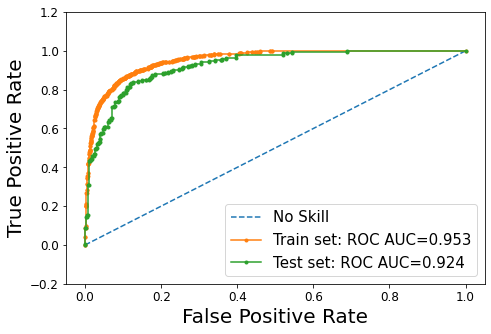

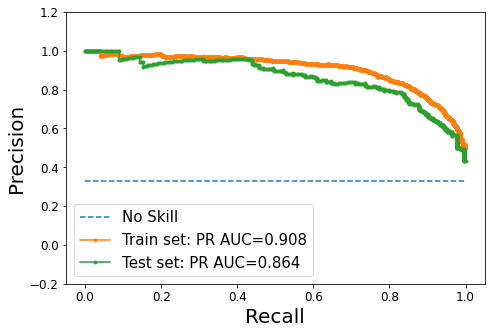

In [32]:
testN=0
res_anal=torch.load('mask'+str(testN)+'_g1.pt')

make_ROC_holdout(res_anal[0], res_anal[1], res_anal[2], res_anal[3], 'ROC')
make_PR_holdout(res_anal[0], res_anal[1], res_anal[2], res_anal[3], 'PR')